In [93]:
import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.nn.functional import pad

# Ginkgo SBI Examples

This notebook contains some baseline examples for performing inference for the rate parameters of Ginkgo in the SBI package. We've been using the versio of ginkgo written for pyprob, but this notebook doesn't use any pyprob-specific features, and it likely the pyro version could be easily substituted. We begin by defining summary statistics for the simulator. We begin by defining the simulator and prior distribution on the two rate parameters.

In [94]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

# Set maxLeaves to 50 - not used in notebook.
ginkgo_simulator_clip = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=50,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

In [95]:
prior_min = [1e-3,1e-3]
prior_max = [30.,30.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Summaries
We consider the full data to be the leaves. The first summary involve flattening the leaves and padding to length 200. We first sort the leaves according to energy. If the flattened data is greater than this length, then we truncate. In most cases, we're unlikely to be truncating:

In [14]:
count = 0
to_truncate = []
for _ in range(2000):
    sample = prior_full.sample()
    if (len(ginkgo_simulator(sample)['leaves']))>50:
        count+=1
        to_truncate.append(sample)
print(count)
print(to_truncate)

22
[tensor([3.7388, 0.9413]), tensor([0.8738, 0.5943]), tensor([3.8216, 0.7047]), tensor([1.0014, 0.8353]), tensor([4.3885, 0.4755]), tensor([3.7820, 1.7459]), tensor([0.3207, 0.9192]), tensor([1.5383, 0.6471]), tensor([2.7359, 1.3874]), tensor([0.0997, 0.0308]), tensor([0.2766, 0.1415]), tensor([5.8230, 1.5074]), tensor([18.5364,  0.8376]), tensor([6.3209, 0.4741]), tensor([26.6979,  0.6101]), tensor([9.7706, 0.2359]), tensor([5.3359, 0.2355]), tensor([6.4797, 0.1496]), tensor([11.3360,  0.1557]), tensor([7.6486, 1.1148]), tensor([6.9769, 0.0774]), tensor([0.9597, 0.9551])]


We can see from the above, that ~1% of samples are truncated. This tends to occur for small values of internal rate. The root rate has smaller impact.

In [4]:
def full_flat(leaves):
    
    flattened = leaves[leaves[:, 0].sort()[1]].reshape(-1)
    
    length = len(flattened)

    if length >= 200:
        return flattened[:200]
    else:
        pad_length = 200 - length
        return pad(flattened,(0,pad_length))

We also define a second set of summaries as the first four moments of the energy. 

In [15]:
def e_summaries(leaves):
    num_leaves = len(leaves)
    energies = leaves[:,0]
    e_mean = energies.mean() # total energy / num leaves
    e_std = energies.std()
    
    def nthmoment(n):
        return torch.sum((energies - e_mean)**n/((num_leaves -1)*e_std**n))

    e_skewness = nthmoment(3)
    e_kurtosis = nthmoment(4)

    return torch.tensor([e_mean, e_std, e_skewness, e_kurtosis])

### Simulator wrapper and observations
For easy compatibility with sbi package, we define the below function.

In [35]:
def get_simulator(summary_fn):

    def simulator(params):
        leaves = ginkgo_simulator(params)['leaves']
        return summary_fn(leaves)

    return simulator

In [36]:
flat_sim = get_simulator(full_flat)
e_sim = get_simulator(e_summaries)

We also define a simple class to capture observations and summaries.

In [43]:
class GinkObs:
    def __init__(self, params):
        self.params = to_tensor(params)
        self.leaves = ginkgo_simulator(params)['leaves']
        self.flat_sum = full_flat(self.leaves)
        self.e_sum = e_summaries(self.leaves)

In [44]:
R3L2 = GinkObs([3,2])
R15L2 = GinkObs([15,2])
R25L2 = GinkObs([25,2])

R25L25 = GinkObs([25,25])

## Single round inference (amortised)

In [38]:
flat_posterior = infer(flat_sim, prior_full, method='SNPE', num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 40 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

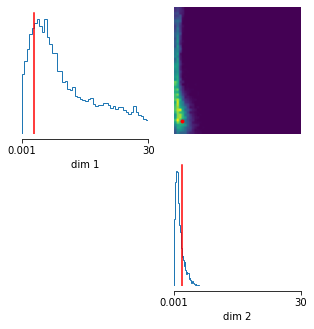

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

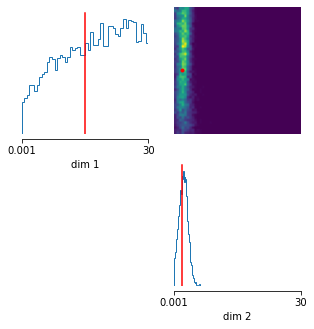

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

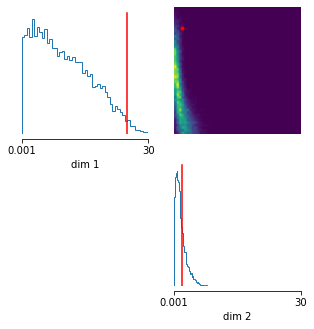

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

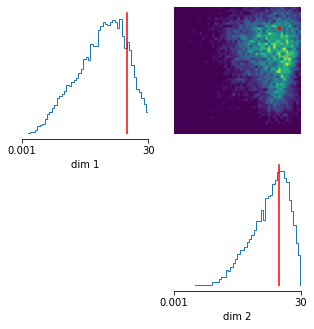

In [65]:
def pair_plt(posterior, obs):
    if posterior == e_posterior:
        samples = posterior.sample((10000,),x=obs.e_sum)
        fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=obs.params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
        plt.show()
    elif posterior == flat_posterior:
        samples = posterior.sample((10000,),x=obs.flat_sum)
        fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=obs.params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
        plt.show()
    

pair_plt(flat_posterior, R3L2)
pair_plt(flat_posterior, R15L2)
pair_plt(flat_posterior, R25L2)
pair_plt(flat_posterior, R25L25)

In [46]:
e_posterior = infer(e_sim, prior_full, method='SNPE', num_simulations=5000, num_workers=7)

Running 5000 simulations in 5000 batches.:   0%|          | 0/5000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 88 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

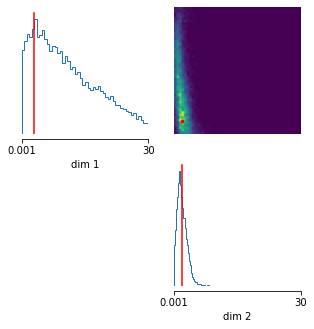

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

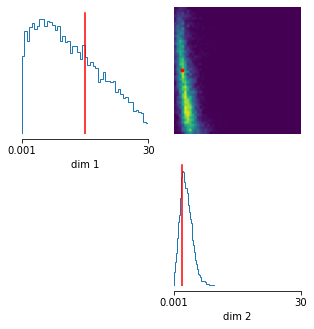

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

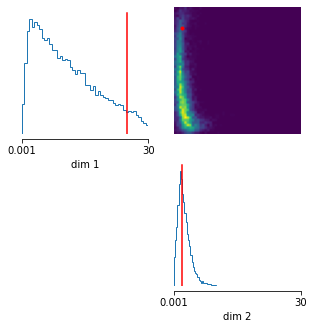

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

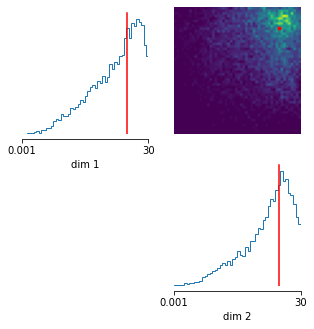

In [66]:

pair_plt(e_posterior, R3L2)
pair_plt(e_posterior, R15L2)
pair_plt(e_posterior, R25L2)
pair_plt(e_posterior, R25L25)

## MSE

In [72]:
def MSE(samples, true_params):
    loss = torch.nn.MSELoss()
    return loss(samples, true_params)
    
def MSE_list(posterior_list, summary_fn_list, param_list, mean = True):

    data_list = [ginkgo_simulator(param)['leaves'] for param in param_list]
    
    assert len(posterior_list) == len(summary_fn_list), "posteriors must be in 1-to-1 correspondence to the summaries"

    MSE_list = []
    for i in range(len(posterior_list)):
        posterior = posterior_list[i]
        summary_fn = summary_fn_list[i]  
        MSE_for_posterior = []
        for j in range(len(data_list)):
            summary = summary_fn(data_list[j])
            samples = posterior.sample((1000,),x=summary,show_progress_bars = False)
            MSE_for_posterior.append(MSE(samples, param_list[j]))

        if mean:
            MSE_list.append(torch.tensor(MSE_for_posterior).mean())
        else:
            MSE_list.append(MSE_for_posterior)

    return MSE_list

In [74]:
posteriors = [flat_posterior, e_posterior]
summary_fns = [full_flat, e_summaries]
print(MSE_list(posteriors, summary_fns, [torch.tensor([3,2])]*100))
print(MSE_list(posteriors, summary_fns, [torch.tensor([15,2])]*100))
print(MSE_list(posteriors, summary_fns, [torch.tensor([25,2])]*100))
print(MSE_list(posteriors, summary_fns, [torch.tensor([25,25])]*100))

[tensor(67.5547), tensor(56.5072)]
[tensor(42.6735), tensor(47.2148)]
[tensor(107.1754), tensor(135.0858)]
[tensor(80.4978), tensor(76.8527)]


## Multiple round inference (doesn't seem to help here)

In [ ]:
num_rounds = 10
flat_posteriors = []
simulator, prior = prepare_for_sbi(flat_sim, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(R3L2)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,30.], [1e-3,30.]],
                            ticks=[[1e-3,30.], [1e-3,30.]],
                            figsize=(5,5),
                            points=np.array([25,25]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
plt.show()

In [78]:
num_rounds = 10
flat_posteriors = []
simulator, prior = prepare_for_sbi(flat_sim, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    flat_posteriors.append(posterior)
    proposal = posterior.set_default_x(R3L2.flat_sum)
    samples = posterior.sample((10000,))
    print(MSE(samples, R3L2.params))

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(72.0215)


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([10000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(78.2599)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(67.6158)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(72.1221)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(78.8591)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(79.7285)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(91.4667)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(87.8022)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(81.6363)


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor(83.0185)


In [79]:
num_rounds = 10
flat_posteriors_2 = []
simulator, prior = prepare_for_sbi(flat_sim, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    flat_posteriors_2.append(posterior)
    proposal = posterior.set_default_x(R25L2.flat_sum)

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 44 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 26 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 21 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 26 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 25 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


 Neural network successfully converged after 25 epochs.

In [91]:
print([MSE(posterior.sample((10000,),x=R3L2.flat_sum, show_progress_bars=False), R3L2.params) for posterior in flat_posteriors])
print([MSE(posterior.sample((10000,),x=R25L2.flat_sum, show_progress_bars=False), R25L2.params) for posterior in flat_posteriors_2])

[tensor(72.8627), tensor(77.2472), tensor(70.4048), tensor(70.9291), tensor(78.9293), tensor(80.6559), tensor(90.9538), tensor(89.1360), tensor(83.9077), tensor(83.0707)]
[tensor(49.4270), tensor(54.1019), tensor(86.2717), tensor(110.1735), tensor(90.7489), tensor(91.5921), tensor(101.6100), tensor(83.0396), tensor(96.6443), tensor(109.7315)]


No clear improvement over multiple rounds. If anything, things get worse.

In [90]:
print([MSE(posterior.sample((10000,),x=R3L2.flat_sum, show_progress_bars=False)[:,0], R3L2.params[0]) for posterior in flat_posteriors])
print([MSE(posterior.sample((10000,),x=R3L2.flat_sum, show_progress_bars=False)[:,1], R3L2.params[1]) for posterior in flat_posteriors])

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[tensor(145.0902), tensor(155.6678), tensor(139.1353), tensor(140.6792), tensor(156.7566), tensor(158.3182), tensor(179.7705), tensor(169.2331), tensor(162.6528), tensor(168.4073)]
[tensor(0.6095), tensor(1.3130), tensor(1.4911), tensor(1.6439), tensor(1.3662), tensor(1.5071), tensor(1.2442), tensor(1.3683), tensor(1.3482), tensor(1.3376)]


In [92]:
print([MSE(posterior.sample((10000,),x=R25L2.flat_sum, show_progress_bars=False)[:,0], R25L2.params[0]) for posterior in flat_posteriors])
print([MSE(posterior.sample((10000,),x=R25L2.flat_sum, show_progress_bars=False)[:,1], R25L2.params[1]) for posterior in flat_posteriors])

[tensor(108.0900), tensor(202.2127), tensor(202.7081), tensor(170.5721), tensor(201.5656), tensor(154.5953), tensor(197.4188), tensor(159.4246), tensor(207.7389), tensor(190.1277)]
[tensor(1.2573), tensor(1.7143), tensor(1.9953), tensor(1.5356), tensor(1.5403), tensor(1.4113), tensor(3.0857), tensor(1.9576), tensor(2.0488), tensor(2.6025)]
